In [20]:
import numpy
import numpy as np
import torch
import torch.nn as nn 
import torch.optim as optim
import random
import pandas as pd
import matplotlib.pyplot as plt

In [21]:
#data_generator
matrix_T = torch.tensor([[0, 1], [1, 0]], dtype=torch.float64)
matrix_U = torch.tensor([[1, -1], [0, 1]], dtype=torch.float64)

inverse_T = torch.inverse(matrix_T)
inverse_U = torch.inverse(matrix_U)

max_moves = 30  #how many inverse operations on the final destination
goal_position = torch.tensor([[1], [0]], dtype=torch.float64)


def data_generator(num_of_datapoints):
    data = torch.empty((num_of_datapoints, 3), dtype=torch.float64)
    for i in range(num_of_datapoints):
        start = goal_position
        moves = random.randint(1, max_moves)
        coin = 3
        for q in range(moves):
            coin = random.randint(0, 1)
            if coin == 1:
                #  print(start, inverse_U, "=")
                start = torch.matmul(inverse_U, start)
            #  print(start)
            else:
                #  print(start, inverse_T, "=")
                start = torch.matmul(inverse_T, start)
                if q != moves - 1:
                    start = torch.matmul(inverse_U, start)
            # print(start)
        # print("done")
        data[i, 0] = start[0]
        data[i, 1] = start[1]
        data[i, 2] = coin
    return data

#https://stackoverflow.com/questions/36158058/torch-save-tensor-to-csv-file#:~:text=For%20simple%20tables%2C%20you%20can,then%20to%20a%20Pandas%20dataframe.&text=You%20can%20first%20convert%20the,table%20as%20a%20csv%20file.
data = data_generator(20000)
data_table = data.numpy()
df = pd.DataFrame(data_table)
df.to_csv("generated_pairs.csv", index = False) 


In [22]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
#https://stackoverflow.com/questions/12336234/read-csv-file-to-numpy-array-first-row-as-strings-rest-as-float
#https://www.w3schools.com/python/numpy/numpy_array_join.asp#:~:text=Joining%20Arrays%20Using%20Stack%20Functions&text=We%20can%20concatenate%20two%201,it%20is%20taken%20as%200.

#make tensors from csv file

#from cs544 notes 
data = pd.read_csv("generated_pairs.csv", names=["0","1","2"], delimiter=",")
dataset = torch.utils.data.TensorDataset(
    torch.tensor(data.loc[:, "0":"1"].values), # input 
    torch.tensor(data.loc[:, ["2"]].values) #output 
)
X, Y = dataset[:] #label input and output 


In [23]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
#making the model 
model = nn.Sequential(
    nn.Linear(2, 128), #first layer 128
    nn.ReLU(),
    nn.Linear(128,64), #second layer 64
    nn.ReLU(),
    nn.Linear(64, 16), #third layer 16
    nn.ReLU(),
    nn.Linear(16,1), #singular output 
    nn.Sigmoid()
)
#print(model)

In [24]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
#prep for training 
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
#prep for training 
loss_function = nn.BCELoss() #should this be our loss function too? 
optimizer = optim.Adam(model.parameters(), lr = 0.001) #chose Adam and lr from site 

#split training and testing data 
train, test = torch.utils.data.random_split(dataset, [0.75, 0.25]) #from cs544 class notes 
X_train, Y_train = train[:]
X_train = torch.Tensor.numpy(X_train)
Y_train = torch.Tensor.numpy(Y_train)


In [25]:
batch_s = 10 #batch size 
epoch_s = 100 #epoch size 
dl = torch.utils.data.DataLoader(train, batch_size = batch_s, shuffle = True) #from cs544 notes 
dl_test = torch.utils.data.DataLoader(test, batch_size = batch_s, shuffle = False)

In [26]:
#https://machinelearningmastery.com/develop-your-first-neural-network-with-pytorch-step-by-step/
for epoch in range(epoch_s):
    for i in range(0, len(X_train), batch_s):
        optimizer.zero_grad()
        X_batch = X_train[i:i+batch_s]
        # print(X_batch)
        y_pred = model(torch.Tensor(X_batch))
        Y_batch = Y_train[i:i+batch_s]
        # print(Y_batch)
        loss = loss_function(y_pred, torch.Tensor(Y_batch))
        
        loss.backward()
        optimizer.step()
        
    print(f'Finished epoch {epoch}, latest loss {loss}')

Finished epoch 0, latest loss 0.0
Finished epoch 1, latest loss 0.0
Finished epoch 2, latest loss 0.0
Finished epoch 3, latest loss 0.0
Finished epoch 4, latest loss 0.0


KeyboardInterrupt: 

In [42]:
def euclidean_algorithm(given_pair): 
    # a = pair[0,0]
    # print(a)
    # b = pair[0,1]
    # print(b)
    a = given_pair[0]
    b = given_pair[1]
    i = 0 #indexing for circle size 
    plt.plot(a.detach(), b.detach(), "bo", markersize = 3 + i)
    while a != 0 or b != 0: 
        pred = model(torch.tensor([[a,b]]))
        if abs(1-pred) < abs(pred): # if prediciton is closer to 1 
            pair = torch.matmul(pair, matrix_U)
        else: 
            pair = torch.matmul(pair, matrix_T)
        a = pair[0,0]
        b = pair[0,1]
        i = i + 1 
        plt.plot(a.detach(), b.detach(), "ro", markersize = 3+i) #from cs544 notes 
    if a == 0: 
        return b
    else: 
        return a 

RuntimeError: mat1 and mat2 must have the same dtype

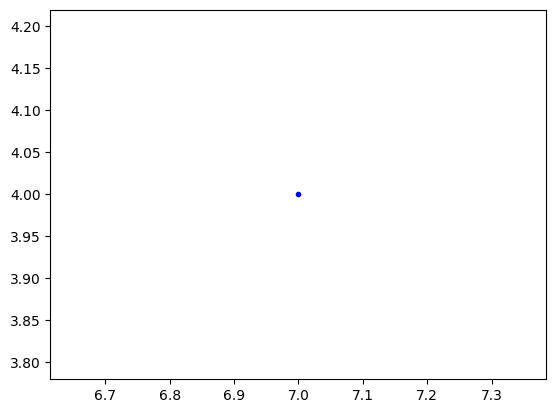

In [43]:
pair = torch.tensor([7,4], dtype=torch.int64)
print(euclidean_algorithm(pair))